# Decision Tree Regression Using Concrete-ML

In this tutorial, we show how to create, train and evaluate a decision tree regression model using Concrete-ML library.



### Introducing Concrete-ML

> Concrete-ML is an open-source, privacy-preserving, machine learning inference framework based on fully homomorphic encryption (FHE).
> It enables data scientists without any prior knowledge of cryptography to automatically turn machine learning models into their FHE equivalent,using familiar APIs from Scikit-learn and PyTorch.
> <cite>&mdash; [Zama documentation](../README.md)</cite>

This tutorial does not require a deep understanding of the technology behind concrete-ML.
Nonetheless, newcomers might be interested in reading introductory sections of the official documentation such as:

- [What is Concrete-ML](../README.md)
- [Key Concepts](../getting-started/concepts.md)

In the tutorial, we will be using the following terminology:

- plaintext: data unprotected, visible to anyone having access to it.
- ciphertext: ciphered data, need to know the secret in order to decipher the data.

Conventional models work with plaintext, where ConcreteML can work directly with ciphertext.
Privacy is preserved as the model does not know the secret and thus cannot decipher the data. 
Yet it outputs a ciphered estimate for the owner of the secret.

## Setup

We will be using California housing prices dataset available in the scikit-learn package.
The data was derived from the 1990 U.S. census, using one row per census block group, where
a block group typically has a population of 600 to 3,000 people.

- Target Variable : Median house value in $100'000
- Number of Observations :  20'640
- Number of Attributes : 8 numeric, predictive attributes
- Attribute Information :
      - MedInc        median income in block group
      - HouseAge      median house age in block group
      - AveRooms      average number of rooms per household
      - AveBedrms     average number of bedrooms per household
      - Population    block group population
      - AveOccup      average number of household members
      - Latitude      block group latitude
      - Longitude     block group longitude

- Missing Attribute Values : None

To speedup computations, we will use a bootstrapped resample of about 5'000 observations.

In [1]:
import sys
import time

import numpy
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

import concrete.ml
from concrete.ml.sklearn import DecisionTreeRegressor as ConcreteDecisionTreeRegressor

print(f"Using ConcreteML version {concrete.ml.version.__version__}")
print(f"With Python version {sys.version}")

Using ConcreteML version 1.5.0-rc0
With Python version 3.8.18 (default, Aug 28 2023, 08:26:46) 
[GCC 9.4.0]


In [2]:
features_all, target_all = fetch_california_housing(return_X_y=True)
features, target = resample(features_all, target_all, replace=True, n_samples=6000, random_state=42)

# Split data in train-test groups
x_train, x_test, y_train, y_test = train_test_split(
    features,
    target,
    test_size=0.15,
    random_state=42,
)

We provide also a quick visualisation of our target variable

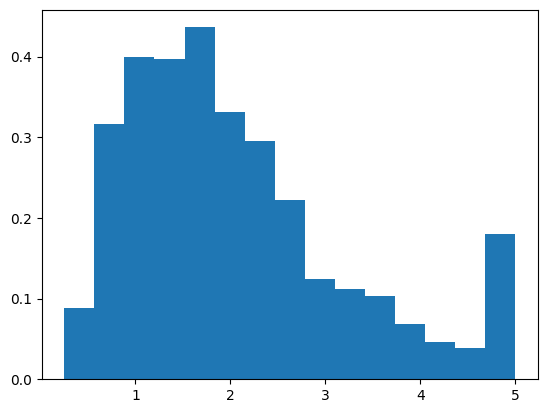

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(target, bins=15, density=True)
plt.show()

## Measuring Accuracy

We choose the mean absolute error as a mesure of accuracy for our models, which has the advantage of preserving the units of measurement, here in dollars.

We will compare our decision trees' to a simpler model (a canary model) to benchmark accuracy. 
We could use the median of the target, but that would perhaps be too basic.
Instead, we expect income to be somewhat proportional to house value, and therefore we use a univariate linear regression model as our canary.

In [4]:
# Utility functions


def print_as_dollars(x):
    """Prints the value * 100'000$"""
    return f"{x * 10**5:.2f}$"


def print_compare_to_baseline(x):
    """Prints percentage improvement over baseline"""
    return f"{(x - baseline_error) / baseline_error * 100 :.2f}% of baseline"


mean_error = mean_absolute_error(y_test, numpy.repeat([numpy.median(y_test)], y_test.shape))
print(f"Mean Absolute Overall Error : {print_as_dollars(mean_error)}")

Mean Absolute Overall Error : 89922.83$


In [5]:
canary = LinearRegression()
canary.fit(x_train[:, :1], y_train)
baseline_error = mean_absolute_error(canary.predict(x_test[:, :1]), y_test)
print(f"Baseline Mean Error : {print_as_dollars(baseline_error)}")

Baseline Mean Error : 62719.65$


## Training A Decision Tree

ConcreteDecisionTreeRegressor is the Concrete-ML equivalent of scikit-learn's DecisionTreeRegressor.
It supports the same parameters and a similar interface, with the extra capability of predicting directly on ciphertext without the need to decipher it, thus preservacy privacy.

Currently, Concrete-ML models must be trained on plaintext. To see how it works, we train a DecisionTreeRegressor with default parameters and estimate its accuracy on test data. Note here that predictions are done on plaintext too, but soon, we will predict on ciphertext.

In [6]:
default_model = ConcreteDecisionTreeRegressor(criterion="absolute_error", n_bits=6, random_state=42)

begin = time.time()
default_model.fit(x_train, y_train)
print(f"Training on {x_train.shape[0]} samples in {(time.time() - begin):.4f} seconds")

Training on 5100 samples in 21.4577 seconds


In [7]:
default_error = mean_absolute_error(default_model.predict(x_test), y_test)
print(
    f"Default Model Mean Error: {print_as_dollars(default_error)},"
    f"{print_compare_to_baseline(default_error)}"
)

Default Model Mean Error: 43788.10$,-30.18% of baseline


## Optimising Hyper Parameters
Working on plaintext is considerably faster than on ciphertext. 
We take this opportunity to search for optimised hyper-parameters for our dataset.
Here we use a GridSearch strategy for simplicity, but could have used any method of our liking.

In [8]:
# Find best hyper parameters with cross validation
from sklearn.model_selection import GridSearchCV

# List of hyper parameters to tune
param_grid = {
    "criterion": ["absolute_error"],
    "random_state": [42],
    "n_bits": [5, 6, 7, 8],
    "max_features": [2, 5, None],
    "min_samples_leaf": [1, 2, 5],
    "min_samples_split": [2, 20, 50],
    "max_depth": [5, 10, 20, None],
}

grid_search = GridSearchCV(
    ConcreteDecisionTreeRegressor(),
    param_grid,
    cv=3,
    scoring="neg_mean_absolute_error",
    error_score="raise",
    n_jobs=10,
)

gs_results = grid_search.fit(x_train, y_train)
print("Best hyper parameters:", gs_results.best_params_)
print(f"Min lost: {print_as_dollars(-gs_results.best_score_)}")

Best hyper parameters: {'criterion': 'absolute_error', 'max_depth': None, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_bits': 8, 'random_state': 42}
Min lost: 43124.69$


### Quantization
You might have noticed we used a hyper-parameter that has no scikit-learn equivalent: `n_bits`. 
This is a first specificity of homomorphic encryption: values must first be represented as (not too big) integers before encryption.
This encoding is called quantization and `n_bits` is related to the maximum size of the quantized values.
Put it simply, lower `n_bits` means that quantization is less precise, but FHE computations are faster.
For more details, see [quantization](../explanations/quantization.md) from the official documentation.

Our model might or not gain from extra precision and/or efficiency. There is a balance to strike for the model between the two and as usual, the right balance depends on context.
For now, we observe that our models performance increases with precision, that is with higher `n_bits`.

In [9]:
# We fix all parameters as the best ones, except for n_bits.
best = gs_results.best_params_
cv_errors = [
    {"n_bits": params["n_bits"], "score": score}
    for params, score in zip(
        gs_results.cv_results_["params"], gs_results.cv_results_["mean_test_score"]
    )
    if (params["max_depth"] == best["max_depth"])
    and (params["max_features"] == best["max_features"])  # noqa: W503
    and (params["min_samples_leaf"] == best["min_samples_leaf"])  # noqa: W503
    and (params["min_samples_split"] == best["min_samples_split"])  # noqa: W503
]
for el in cv_errors:
    print(f"Error for n_bits={el['n_bits']} is {print_as_dollars(-el['score'])}")

Error for n_bits=5 is 48955.72$
Error for n_bits=6 is 46599.48$
Error for n_bits=7 is 44158.68$
Error for n_bits=8 is 43124.69$


## Training the Optimised Model
We now train our model with the optimised hyper-parameters.
Firstly, to show how it works, let us fix `n_bits` to a lower value so that compute time remains reasonable.
Once done, we will then see how higher values of `n_bits` affect compute time.
We also use `fit_benchmark` method instead of `fit` to easily compare our model to its scikit-learn equivalent.

In [10]:
# Build the model with best hyper parameters
model = ConcreteDecisionTreeRegressor(
    max_features=gs_results.best_params_["max_features"],
    min_samples_leaf=gs_results.best_params_["min_samples_leaf"],
    min_samples_split=gs_results.best_params_["min_samples_split"],
    max_depth=gs_results.best_params_["max_depth"],
    n_bits=6,
    random_state=42,
)

In [11]:
model, sklearn_model = model.fit_benchmark(x_train, y_train)

In [12]:
# Compute average precision on test
y_pred_concrete = model.predict(x_test)
y_pred_sklearn = sklearn_model.predict(x_test)
concrete_average_precision = mean_absolute_error(y_test, y_pred_concrete)
sklearn_average_precision = mean_absolute_error(y_test, y_pred_sklearn)
print(
    f"Sklearn  Mean Error: {print_as_dollars(sklearn_average_precision)},"
    f"{print_compare_to_baseline(sklearn_average_precision)}"
)
print(
    f"Concrete Mean Error: {print_as_dollars(concrete_average_precision)},"
    f"{print_compare_to_baseline(concrete_average_precision)}"
)

Sklearn  Mean Error: 41418.11$,-33.96% of baseline
Concrete Mean Error: 40695.02$,-35.12% of baseline


We see that the concrete model has similar performance to the scikit-learn model.
However, there can be a difference as concrete models perform a possibly lossy quantization of the data.
We should expect in general the accuracy to be slightly lower for concrete models, but this is not always the case as models are themselves approximations.

## Predicting on Ciphertext
If the predictions are similar although slightly less accurate, the real advantage of ConcreteML is privacy.
We now show how we can perform prediction on ciphertext with Concrete-ML, so that the model does not need to decipher the data at all to compute its estimate.

### Setup
In order to prepare our model to work directly on ciphertext, we need to:

  - Compile the model to a circuit: the circuit represents our model's prediction program in FHE operations.
  - Generate an encryption key for our circuit.
  
When deploying the model as a service in a client-server architecture, the server compiles the model and serves it, where the client generates the key and keeps it secret. The client uses its secret key to first encrypt then send data to the server.

Note that in order to compile the circuit, the compiler needs to have some examples of the data it will be using.
We use here all our training data as a sample, increasing the compile time, but making it safer.

In [13]:
x_train_subset = x_train[:500]

begin = time.time()
circuit = model.compile(x_train_subset)
print(f"Compiled with {len(x_train_subset)} samples in {(time.time() - begin):.4f} seconds")

Compiled with 5100 samples in 83.1571 seconds


In [14]:
print(f"Generating a key for an {circuit.graph.maximum_integer_bit_width()}-bit circuit")
time_begin = time.time()
circuit.client.keygen(force=False)
print(f"Key generation time: {time.time() - time_begin:.2f} seconds")

Generating a key for an 8-bit circuit
Key generation time: 0.49 seconds


### Prediction 
Prediction can be done directly on ciphertext by passing the fhe="execute" argument to the predict method.
Note however that computations on ciphertext are slower than on plaintext.
In order to get results quickly for this tutorial, we show predictions only on a few observations of the test sample.

In [15]:
FHE_SAMPLES = 3
x_test_small = x_test[:FHE_SAMPLES]
y_pred = y_pred_concrete[:FHE_SAMPLES]

In [16]:
# Predict in FHE for a few examples
time_begin = time.time()
y_pred_fhe = model.predict(x_test_small, fhe="execute")
print(f"Execution time: {(time.time() - time_begin) / FHE_SAMPLES:.2f} seconds per sample")

Execution time: 7.52 seconds per sample


We have previously obtained predictions from plaintext.
We now show that the estimates from plaintext or ciphertext in our setting are the same.
In general, they might slightly differ due to the addition of noise in ciphertext.

In [17]:
# Check prediction FHE vs sklearn
print("Cipher estimates:")
print(f"{', '.join(f'{print_as_dollars(x)}' for x in y_pred_fhe)}")
print("Plain estimates:")
print(f"{', '.join(f'{print_as_dollars(x)}' for x in y_pred)}")
print("Differences:")
print(f"{', '.join(f'{print_as_dollars(x)}' for x in (y_pred_fhe - y_pred))}")

Cipher estimates:
293651.38$, 166667.00$, 126984.38$
Plain estimates:
293651.38$, 166667.00$, 126984.38$
Differences:
0.00$, 0.00$, 0.00$


### Compute Times
We finish this tutorial with an evaluation of accuracy and compute times as we increase `n_bits` parameters.
If you wish to recompute this cell, please note that it takes a long time to complete.

In [18]:
# Concatenate all the steps in one function of n_bits


def evaluate(n_bits):
    model = ConcreteDecisionTreeRegressor(
        max_features=gs_results.best_params_["max_features"],
        min_samples_leaf=gs_results.best_params_["min_samples_leaf"],
        min_samples_split=gs_results.best_params_["min_samples_split"],
        max_depth=gs_results.best_params_["max_depth"],
        n_bits=n_bits,
        random_state=42,
    )
    model, sklearn_model = model.fit_benchmark(x_train, y_train)
    y_pred_concrete = model.predict(x_test)
    y_pred_sklearn = sklearn_model.predict(x_test)
    concrete_average_precision = mean_absolute_error(y_test, y_pred_concrete)
    sklearn_average_precision = mean_absolute_error(y_test, y_pred_sklearn)
    print(
        f"Sklearn  Mean Error: {print_as_dollars(sklearn_average_precision)},"
        f"{print_compare_to_baseline(sklearn_average_precision)}"
    )
    print(
        f"Concrete Mean Error: {print_as_dollars(concrete_average_precision)},"
        f"{print_compare_to_baseline(concrete_average_precision)}"
    )
    begin = time.time()
    circuit = model.compile(x_train)
    print(f"Circuit compiled with {len(x_train)} samples in {(time.time() - begin):.4f} seconds")
    print(f"Generating a key for an {circuit.graph.maximum_integer_bit_width()}-bit circuit")
    time_begin = time.time()
    circuit.client.keygen(force=False)
    print(f"Key generation time: {time.time() - time_begin:.2f} seconds")
    time_begin = time.time()
    model.predict(x_test_small, fhe="execute")
    print(f"Execution time: {(time.time() - time_begin) / FHE_SAMPLES:.2f} seconds per sample")


for n_bits in [7, 8]:
    header = f"N_BITS = {n_bits}"
    print(header)
    print("-" * len(header))
    evaluate(n_bits)
    print()

N_BITS = 7
----------


Sklearn  Mean Error: 41418.11$,-33.96% of baseline
Concrete Mean Error: 40483.27$,-35.45% of baseline


Circuit compiled with 5100 samples in 114.1739 seconds
Generating a key for an 9-bit circuit
Key generation time: 0.41 seconds


Execution time: 8.35 seconds per sample

N_BITS = 8
----------


Sklearn  Mean Error: 41418.11$,-33.96% of baseline
Concrete Mean Error: 40725.84$,-35.07% of baseline


Circuit compiled with 5100 samples in 123.1487 seconds
Generating a key for an 10-bit circuit
Key generation time: 0.41 seconds


Execution time: 7.80 seconds per sample



We see that increasing `n_bits` can increase dramatically the computation times making them prohibitive.
Yet better quantization precision does not necessarily lower the generalization error of the model, as estimates are already appproximations in some sense.

## Conclusion
Using a decision tree regressor in concrete-ML is very similar to using it through scikit-learn and can be done in a few lines of code.
Data-scientists can now use concrete-ML to perform privacy-preserving decision tree regression on encrypted data.

### Going Further
Some additional tools can smooth up the development workflow:

  - Selecting relevant bit-size for [quantizing](../explanations/quantization.md) the model.
  - Alleviating the [compilation](../explanations/compilation.md) time by making use of [FHE simulation](../explanations/compilation.md#fhe-simulation)

Once the model is carefully trained and quantized, it is ready to be deployed and used in production. Here are some useful links on the subject:
    
  - [Inference in the Cloud](../getting-started/cloud.md) summarize the steps for cloud deployment
  - [Production Deployment](../guides/client_server.md) offers a high-level view of how to deploy a Concrete-ML model in a client/server setting.
  - [Client Server in Concrete ML](./ClientServer.ipynb) provides a more hands-on approach as another tutorial.